In [1]:
import os
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import warnings
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
# own python extension
import tnCounter

In [2]:
def split_fragment(sequence, n):
    """
    Split sequence into fragments no longer than n
    
    Inputs:
    sequence - sequence
    n - max length of fragment
    
    Output - fragments
    """
    for i in range(0, len(sequence), n):
        yield str(sequence[i:i + n])
        

def split_overlap(sequence, n, overlap):
    """
    Split sequence into fragments no longer than n
    (with overlap)
    
    Inputs:
    sequence - sequence
    n - max length of fragment
    
    Output - fragments
    """
    for i in range(0, len(sequence), round(n/overlap)):
        yield str(sequence[i:i+n])


def opt_len(s,l):
    """add docstring"""
    return math.ceil(len(s)/round(len(s)/l))
    

def getContigTNF(path, min_length, windowsize, verbose=False):
    """add docstring"""
    contigs = SeqIO.parse(path, 'fasta')

    contigs_tnf = []
    for record in contigs:
        seq = record.seq  
        if len(seq) > min_length:
            for fragment in split_fragment(seq, opt_len(seq, windowsize)):
                tnf = tnCounter.count(fragment)
                contigs_tnf.append(tnf)
        elif verbose:
            print("Warning: contig {} to small, it will be skipped".format(record.name)) 
    
    return(contigs_tnf)


def write_tnf(tnf, fname):
    """add docstring"""
    df = pd.DataFrame(tnf)
    df.to_csv(fname, header=True, index=False)


def new_z(contigs):
    mean = contigs.mean(axis=0)
    fractions = mean/mean.sum()
    E = np.dot(contigs.sum(axis=1).reshape(contigs.shape[0],1),
        fractions.reshape(1,contigs.shape[1]))
    z_scores = (contigs - E)/np.sqrt(E)
    return z_scores


def estimate_contamination(X, verbose):
    """ Add Docstring """

    pca = PCA()
    pca.fit(X)
    pca_data = pca.transform(X)

    clust = OPTICS(min_samples=50, xi=0.005, min_cluster_size=.05)
    
    if not verbose:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clust.fit(pca_data[:,:20])
    else:
        clust.fit(pca_data[:,:20])

    clusters = set(clust.labels_)
    if -1 in clusters:
        clusters.remove(-1)
    number_of_clusters = len(clusters)

    gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full')

    tmp = []
    for c in clusters:
        tmp.append(pca_data[clust.labels_ == c].mean(axis=0))

    est_contamination = 0 
    if number_of_clusters > 1:
        initial = np.array(tmp)

        gmm.fit(initial[:,:8])
        gmm.set_params(warm_start=True)

        labels = gmm.fit_predict(pca_data[:,:8])
        _, cluster_counts = np.unique(labels, return_counts=True)

        cont = np.min(cluster_counts)
        est_contamination = cont/np.sum(cluster_counts)

    return est_contamination

In [169]:
### False negatives:
#f = "../benchmark/MetaBat/MetaBATMed/bin.5.fa"
#f = "../benchmark/MetaBat/MetaBATMed/bin.81.fa"   
#f = "../benchmark/MetaBat/MetaBATMed/bin.98.fa"
#f = "../benchmark/MetaBat/MetaBATHigh/bin.149.fa"
#f = "../benchmark/MetaBat/MetaBATHigh/bin.349.fa"
#f = "../benchmark/MetaBat/MetaBATHigh/bin.511.fa"
#f = "../benchmark/MetaBat/MetaBATMed/bin.159.fa"     #Big 
f = "../benchmark/MetaBat/MetaBATMed/bin.129.fa"     #Big


### False positives:
#f = "../benchmark/MetaBat/MetaBATMed/bin.78.fa" # DOUBLE CHECK THAT ONE
#f = "../benchmark/MetaBat/MetaBATHigh/bin.692.fa"

#f = "../benchmark/MetaBat/MetaBATMed/bin.129.fa"
X = getContigTNF(f, 8000, 15000, False)
X = new_z(np.array(X))
# = preprocessing.StandardScaler().fit_transform(X)
#scaler = preprocessing.PowerTransformer(method='box-cox', standardize=False)
#X = scaler.fit_transform(X)

In [170]:
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

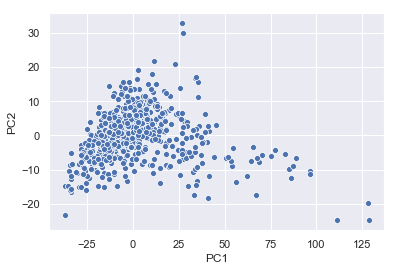

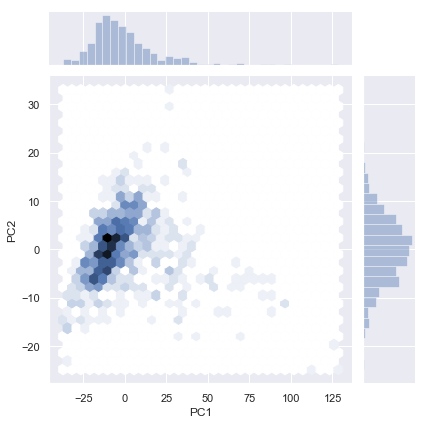

In [171]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])

sns.scatterplot(x='PC1', y='PC2',  data=pca_df)
sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")

In [172]:
clust = OPTICS(min_samples=50, xi=0.005, min_cluster_size=0.05)
clust.fit(pca_data[:,:20])

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=50, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.005)

In [173]:
space = np.arange(len(pca_data))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

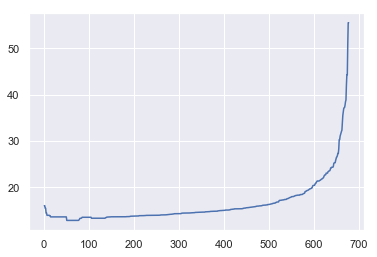

In [174]:
plt.plot(space,reachability)

In [175]:
clusters = set(clust.labels_)
if -1 in clusters:
    clusters.remove(-1)
number_of_clusters = len(clusters)
clusters

{0, 1}

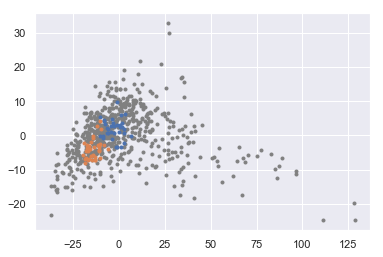

In [176]:
noise = pca_data[clust.labels_ == -1]
X1 = pca_data[clust.labels_ == 0]
X2 = pca_data[clust.labels_ == 1]
plt.plot(noise[:,0], noise[:,1], '.', color='gray')
plt.plot(X1[:,0], X1[:,1], '.')
plt.plot(X2[:,0], X2[:,1], '.')
plt.show()

In [177]:
estimate_contamination(X,False)

0.18409425625920472

## Sampling

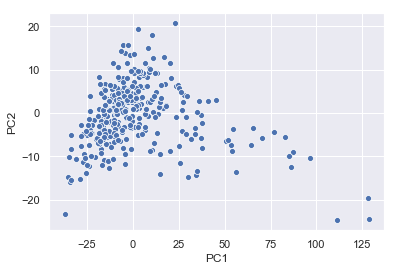

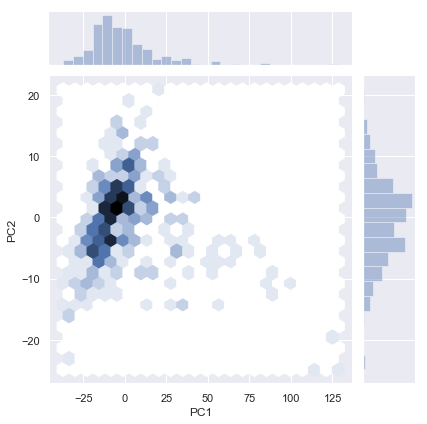

In [178]:
sample = pca_df.sample(frac=0.5)
sns.scatterplot(x='PC1', y='PC2',  data=sample)
sns.jointplot(x='PC1', y='PC2', data=sample, kind="hex")

In [179]:
Xs = sample.values
clust = OPTICS(min_samples=50, xi=0.005, min_cluster_size=0.01)
clust.fit(Xs[:,:20])

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.01, min_samples=50, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.005)

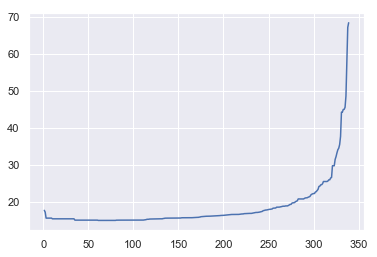

In [180]:
space = np.arange(len(Xs))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
plt.plot(space,reachability)

In [181]:
clusters = set(clust.labels_)
if -1 in clusters:
    clusters.remove(-1)
number_of_clusters = len(clusters)
clusters

{0}

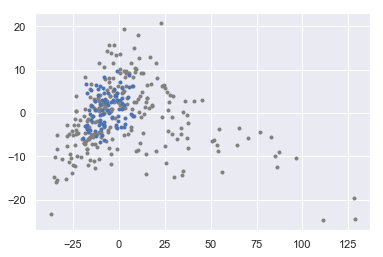

In [182]:
noise = Xs[clust.labels_ == -1]
X1 = Xs[clust.labels_ == 0]
X2 = Xs[clust.labels_ == 1]
plt.plot(noise[:,0], noise[:,1], '.', color='gray')
plt.plot(X1[:,0], X1[:,1], '.')
plt.plot(X2[:,0], X2[:,1], '.')
plt.show()